***
# Lab 2 ML7331
> ### By Allen Hoskins, Brittany Lewandowski, Alexy Morris, Fidel Tamares


***

In [128]:
#import packages
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sk
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_predict
from sklearn.linear_model import LogisticRegression,SGDClassifier,LogisticRegressionCV, ElasticNet
from sklearn.feature_selection import SelectPercentile,f_regression
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import matplotlib
from graphviz.graphs import Digraph
from mlxtend.evaluate import paired_ttest_5x2cv
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
import time
import warnings

In [ ]:
#remove warnings after verifying code
warnings.filterwarnings("ignore")

***
# Data Preparation 1
Define and prepare your class variables. <br> 
> The team used a data set from Kaggle containing attributes about 2015 airline delays. The meaningfulness of the data is to provide both airlines and customers with information relevant to flight delays. This data is useful as it helps customers make decisions about which airline they fly with, and it helps airlines determine what the cause(s) of flight delays are. From a business perspective, knowing this information is critical as it drives an organization’s bottom line.  

> To get better insight into the attributes contained in the data set and their data types, the team ran `df.info(verbose=True,show_counts=True)` in Python. 

Use proper variable representations (int, float, one-hot, etc.).<br>

Initially starting with the three data sets they contain the following details: <br>
Flights:
> 1. The data set contains 5,819,079 entries.<br> 
> 2. The data set contains 31 columns.  <br>
> 3. There are 16 columns classified with the data type, float.<br>
> 4. There are 10 columns classified with the data type, int. <br>
> 5. There are 5 columns classified with the data type, object.

Airports:
> 1. The data set contains 322 entries.<br> 
> 2. The data set contains 7 columns.  <br>
> 3. There are 2 columns classified with the data type, float.<br>
> 4. There are 5 columns classified with the data type, object.

Airlines:
> 1. The data set contains 14 entries.<br> 
> 2. The data set contains 2 columns.  <br>
> 3. There are 2 columns classified with the data type, object. </font>

Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. <br>
> PCA was used preprocessing step to help scales the numeric predictors before fitting out selected models.

Remove variables that are not needed/useful for the analysis
> As we analyzed the initial datasets there were a lot of redudnat variables that represented the same type of information. Data points such as IATA_Code (The International Air Transport Association's) to identify an airport and the actual airports name. We also found some data points that we determined would not be important to classifying flight delays such as Flight_Number, cancellation_reason or tail_number
***

In [2]:
df_flights = pd.read_csv(r'/Users/allen/Desktop/MSDS/ML1/archive/flights.csv',low_memory = False)

In [3]:
df_flights.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5819079 entries, 0 to 5819078
Data columns (total 31 columns):
 #   Column               Dtype  
---  ------               -----  
 0   YEAR                 int64  
 1   MONTH                int64  
 2   DAY                  int64  
 3   DAY_OF_WEEK          int64  
 4   AIRLINE              object 
 5   FLIGHT_NUMBER        int64  
 6   TAIL_NUMBER          object 
 7   ORIGIN_AIRPORT       object 
 8   DESTINATION_AIRPORT  object 
 9   SCHEDULED_DEPARTURE  int64  
 10  DEPARTURE_TIME       float64
 11  DEPARTURE_DELAY      float64
 12  TAXI_OUT             float64
 13  WHEELS_OFF           float64
 14  SCHEDULED_TIME       float64
 15  ELAPSED_TIME         float64
 16  AIR_TIME             float64
 17  DISTANCE             int64  
 18  WHEELS_ON            float64
 19  TAXI_IN              float64
 20  SCHEDULED_ARRIVAL    int64  
 21  ARRIVAL_TIME         float64
 22  ARRIVAL_DELAY        float64
 23  DIVERTED             int64  
 24

In [4]:
df_airports = pd.read_csv(r'/Users/allen/Desktop/MSDS/ML1/archive/airports.csv',low_memory = False)

In [5]:
df_airports.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IATA_CODE  322 non-null    object 
 1   AIRPORT    322 non-null    object 
 2   CITY       322 non-null    object 
 3   STATE      322 non-null    object 
 4   COUNTRY    322 non-null    object 
 5   LATITUDE   319 non-null    float64
 6   LONGITUDE  319 non-null    float64
dtypes: float64(2), object(5)
memory usage: 17.7+ KB


In [6]:
df_airlines = pd.read_csv(r'/Users/allen/Desktop/MSDS/ML1/archive/airlines.csv',low_memory = False)

In [7]:
df_airlines.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   IATA_CODE  14 non-null     object
 1   AIRLINE    14 non-null     object
dtypes: object(2)
memory usage: 352.0+ bytes


In [8]:
pd.set_option('display.max_columns', None)

In [9]:
#merge flight and airline information
df_merge_airline = df_flights.merge(df_airlines, left_on = 'AIRLINE', right_on = 'IATA_CODE',how='left')
df_merge_airline.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE_x,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,IATA_CODE,AIRLINE_y
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,-11.0,21.0,15.0,205.0,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,AS,Alaska Airlines Inc.
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,-8.0,12.0,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,AA,American Airlines Inc.
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.0,-2.0,16.0,34.0,286.0,293.0,266.0,2296,800.0,11.0,806,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,US,US Airways Inc.
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,-5.0,15.0,30.0,285.0,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,AA,American Airlines Inc.
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,24.0,-1.0,11.0,35.0,235.0,215.0,199.0,1448,254.0,5.0,320,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,AS,Alaska Airlines Inc.


In [10]:
#find airports with missing LATITUDE
df_airports[df_airports['LATITUDE'].isna() == True]

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
96,ECP,Northwest Florida Beaches International Airport,Panama City,FL,USA,NaN,NaN
234,PBG,Plattsburgh International Airport,Plattsburgh,NY,USA,NaN,NaN
313,UST,Northeast Florida Regional Airport (St. August...,St. Augustine,FL,USA,NaN,NaN


In [11]:
#merge origin airport information to merged data 
df_merge_origin = df_merge_airline.merge(df_airports, left_on = 'ORIGIN_AIRPORT',right_on = 'IATA_CODE', how='left')
df_merge_origin.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE_x,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,IATA_CODE_x,AIRLINE_y,IATA_CODE_y,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,-11.0,21.0,15.0,205.0,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,AS,Alaska Airlines Inc.,ANC,Ted Stevens Anchorage International Airport,Anchorage,AK,USA,61.17432,-149.99619
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,-8.0,12.0,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,AA,American Airlines Inc.,LAX,Los Angeles International Airport,Los Angeles,CA,USA,33.94254,-118.40807
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.0,-2.0,16.0,34.0,286.0,293.0,266.0,2296,800.0,11.0,806,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,US,US Airways Inc.,SFO,San Francisco International Airport,San Francisco,CA,USA,37.61900,-122.37484
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,-5.0,15.0,30.0,285.0,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,AA,American Airlines Inc.,LAX,Los Angeles International Airport,Los Angeles,CA,USA,33.94254,-118.40807
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,24.0,-1.0,11.0,35.0,235.0,215.0,199.0,1448,254.0,5.0,320,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,AS,Alaska Airlines Inc.,SEA,Seattle-Tacoma International Airport,Seattle,WA,USA,47.44898,-122.30931


In [12]:
rename_dict_origin =  {'CITY':'CITY_ORIGIN',
                'STATE':'STATE_ORIGIN',
                'COUNTRY':'COUNTRY_ORIGIN',
                'LATITUDE':'LATITUDE_ORIGIN',
                'LONGITUDE':'LONGITUDE_ORIGIN'}
df_merge_origin.rename(columns=rename_dict_origin,inplace = True)

df_merge_origin.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE_x,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,IATA_CODE_x,AIRLINE_y,IATA_CODE_y,AIRPORT,CITY_ORIGIN,STATE_ORIGIN,COUNTRY_ORIGIN,LATITUDE_ORIGIN,LONGITUDE_ORIGIN
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,-11.0,21.0,15.0,205.0,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,AS,Alaska Airlines Inc.,ANC,Ted Stevens Anchorage International Airport,Anchorage,AK,USA,61.17432,-149.99619
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,-8.0,12.0,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,AA,American Airlines Inc.,LAX,Los Angeles International Airport,Los Angeles,CA,USA,33.94254,-118.40807
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.0,-2.0,16.0,34.0,286.0,293.0,266.0,2296,800.0,11.0,806,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,US,US Airways Inc.,SFO,San Francisco International Airport,San Francisco,CA,USA,37.61900,-122.37484
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,-5.0,15.0,30.0,285.0,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,AA,American Airlines Inc.,LAX,Los Angeles International Airport,Los Angeles,CA,USA,33.94254,-118.40807
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,24.0,-1.0,11.0,35.0,235.0,215.0,199.0,1448,254.0,5.0,320,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,AS,Alaska Airlines Inc.,SEA,Seattle-Tacoma International Airport,Seattle,WA,USA,47.44898,-122.30931


In [13]:
#merge destination airport information to dataset
df_merge_final = df_merge_origin.merge(df_airports,left_on = 'DESTINATION_AIRPORT',right_on = 'IATA_CODE',how='left')
df_merge_final.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE_x,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,IATA_CODE_x,AIRLINE_y,IATA_CODE_y,AIRPORT_x,CITY_ORIGIN,STATE_ORIGIN,COUNTRY_ORIGIN,LATITUDE_ORIGIN,LONGITUDE_ORIGIN,IATA_CODE,AIRPORT_y,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,-11.0,21.0,15.0,205.0,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,AS,Alaska Airlines Inc.,ANC,Ted Stevens Anchorage International Airport,Anchorage,AK,USA,61.17432,-149.99619,SEA,Seattle-Tacoma International Airport,Seattle,WA,USA,47.44898,-122.30931
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,-8.0,12.0,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,AA,American Airlines Inc.,LAX,Los Angeles International Airport,Los Angeles,CA,USA,33.94254,-118.40807,PBI,Palm Beach International Airport,West Palm Beach,FL,USA,26.68316,-80.09559
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.0,-2.0,16.0,34.0,286.0,293.0,266.0,2296,800.0,11.0,806,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,US,US Airways Inc.,SFO,San Francisco International Airport,San Francisco,CA,USA,37.61900,-122.37484,CLT,Charlotte Douglas International Airport,Charlotte,NC,USA,35.21401,-80.94313
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,-5.0,15.0,30.0,285.0,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,AA,American Airlines Inc.,LAX,Los Angeles International Airport,Los Angeles,CA,USA,33.94254,-118.40807,MIA,Miami International Airport,Miami,FL,USA,25.79325,-80.29056
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,24.0,-1.0,11.0,35.0,235.0,215.0,199.0,1448,254.0,5.0,320,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,AS,Alaska Airlines Inc.,SEA,Seattle-Tacoma International Airport,Seattle,WA,USA,47.44898,-122.30931,ANC,Ted Stevens Anchorage International Airport,Anchorage,AK,USA,61.17432,-149.99619


In [14]:
rename_dict_dest =  {'CITY':'CITY_DESTINATION',
                'STATE':'STATE_DESTINATION',
                'COUNTRY':'COUNTRY_DESTINATION',
                'LATITUDE':'LATITUDE_DESTINATION',
                'LONGITUDE':'LONGITUDE_DESTINATION'}
df_merge_final.rename(columns=rename_dict_dest,inplace = True)

df_merge_final.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE_x,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,IATA_CODE_x,AIRLINE_y,IATA_CODE_y,AIRPORT_x,CITY_ORIGIN,STATE_ORIGIN,COUNTRY_ORIGIN,LATITUDE_ORIGIN,LONGITUDE_ORIGIN,IATA_CODE,AIRPORT_y,CITY_DESTINATION,STATE_DESTINATION,COUNTRY_DESTINATION,LATITUDE_DESTINATION,LONGITUDE_DESTINATION
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,-11.0,21.0,15.0,205.0,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,AS,Alaska Airlines Inc.,ANC,Ted Stevens Anchorage International Airport,Anchorage,AK,USA,61.17432,-149.99619,SEA,Seattle-Tacoma International Airport,Seattle,WA,USA,47.44898,-122.30931
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,-8.0,12.0,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,AA,American Airlines Inc.,LAX,Los Angeles International Airport,Los Angeles,CA,USA,33.94254,-118.40807,PBI,Palm Beach International Airport,West Palm Beach,FL,USA,26.68316,-80.09559
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.0,-2.0,16.0,34.0,286.0,293.0,266.0,2296,800.0,11.0,806,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,US,US Airways Inc.,SFO,San Francisco International Airport,San Francisco,CA,USA,37.61900,-122.37484,CLT,Charlotte Douglas International Airport,Charlotte,NC,USA,35.21401,-80.94313
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,-5.0,15.0,30.0,285.0,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,AA,American Airlines Inc.,LAX,Los Angeles International Airport,Los Angeles,CA,USA,33.94254,-118.40807,MIA,Miami International Airport,Miami,FL,USA,25.79325,-80.29056
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,24.0,-1.0,11.0,35.0,235.0,215.0,199.0,1448,254.0,5.0,320,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,AS,Alaska Airlines Inc.,SEA,Seattle-Tacoma International Airport,Seattle,WA,USA,47.44898,-122.30931,ANC,Ted Stevens Anchorage International Airport,Anchorage,AK,USA,61.17432,-149.99619


In [15]:
df_merge_final.columns= df_merge_final.columns.str.strip().str.lower()

In [16]:
df_ordered = df_merge_final.copy(deep=True)

In [17]:
col_order = ['year','month','day','day_of_week','airline_x','airline_y','flight_number','tail_number',
             'origin_airport','airport_x','city_origin','state_origin','country_origin','latitude_origin','longitude_origin',
             'destination_airport','airport_y','city_destination','state_destination','country_destination','latitude_destination','longitude_destination',
             'scheduled_departure','departure_time','departure_delay','taxi_out','wheels_off','scheduled_time','elapsed_time','air_time','distance',
             'wheels_on','taxi_in','scheduled_arrival','arrival_time','arrival_delay','diverted','cancelled','cancellation_reason','air_system_delay',
             'security_delay','airline_delay','late_aircraft_delay','weather_delay']

In [18]:
df_ordered = df_ordered[col_order]

In [19]:
rename_dict_merged =  {'airline_x':'airline_cd',
                       'airline_y':'airline_name',
                       'airport_x': 'airport_origin',
                       'airport_y':'airport_destination'}
df_ordered.rename(columns=rename_dict_merged,inplace = True)

In [20]:
df_ordered.to_csv(r'/Users/allen/Desktop/MSDS/ML1/archive/airline_merged.csv')

***
# Data Preparation 2
Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created).

The final data set that we started our analysis with was named airlines_merged and contained the following details:
> 1. The data set contains 5,819,079 entries.<br> 
> 2. The data set contains 45 columns.  <br>
> 3. There are 20 columns classified with the data type, float.<br>
> 4. There are 11 columns classified with the data type, int. <br>
> 5. There are 14 columns classified with the data type, object.

The __5,819,079x45 Data Frame__ is sufficient size for us to conduct our analysis and classification of future flights. <br>
We have also included a data ditionary to better explain the purpose of each predictor. 

**Newly Created Fields:**
> Because we want to predict if an airplane is going to be delayed or not using classification models, we created a new field called `is_delay` from the `departure_delay` field. To do this, we created a function that we could pass a numeric field through and if the value for that row is greater than 0, we imputed "1" into the curated field to signifiy the flight was delayed. If the value was less than 0, we imputed "0" to signify that the flight was not delayed. 

> After creating the `is_delay` field, we then began to One Hot Encode any categorial variables so that our model could interpret and use those columns. This caused a 250k by 42 data set to become 240k by 3400.

> All fields with data types that are not integer or float will be removed as they are One Hot Encoded.
***

In [21]:
df = pd.read_csv(r'/Users/allen/Desktop/MSDS/ML1/archive/airline_merged.csv',low_memory=False)

In [22]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5819079 entries, 0 to 5819078
Data columns (total 45 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Unnamed: 0             int64  
 1   year                   int64  
 2   month                  int64  
 3   day                    int64  
 4   day_of_week            int64  
 5   airline_cd             object 
 6   airline_name           object 
 7   flight_number          int64  
 8   tail_number            object 
 9   origin_airport         object 
 10  airport_origin         object 
 11  city_origin            object 
 12  state_origin           object 
 13  country_origin         object 
 14  latitude_origin        float64
 15  longitude_origin       float64
 16  destination_airport    object 
 17  airport_destination    object 
 18  city_destination       object 
 19  state_destination      object 
 20  country_destination    object 
 21  latitude_destination   float64
 22  longitude_destinat


**Data Dictionary:**
***

| Attribute Name | Attribute Description | Non-null Count | Attribute Data Type|
| :--- | :--- | :---| :---|
| year | Year data was collected |5819079|int |
| month | Month data was collected |5819079| int |
| day | Day data was collected (1-25) |5819079| int |
| day_of_week | Day of the week data was collected (1-7) |5819079|int |
| airline_name | Name of airline ex) Alaska Airlines Inc. |5819079| object |
| airline_cd | Code for airline ex) AA |5819079|object |
| flight_number | Unique identifier for each flight |5804358| int |
| tail_number  | Unique identifier for a plane | 5819079|object |
| origin_airport | Code of origin airport ex) DFW for Dallas Fort Worth International Airport |5819079| object |
| airport_origin | Airport flight originates from ex) San Francisco International Airport  | 5332914|object  |
| city_origin | City the flight came from | 5332914|object |
| state_origin | State the flight came from | 5332914|object |
| country_origin | Country flight came from | 5332914|object |
| latitude_origin | Latitude coordinates the flight came from | 5332914|float |
| longitude_origin | Longitude coordinates the flight came from | 5332914|float |
| destination_airport | Code of destination airport ex) DFW for Dallas Fort Worth International Airport |5819079| object |
| airport_destination | Name of destination airport ex) Dallas Fort Worth International Airport |5332914|	object |
| city_destination | City of destination | 5332914|object |
| state_destination | State of destination | 5332914|object |
| country_destination | Country of destination |5332914| object |
| latitude_destination | Latitude coordinates of flight destination | 5332914|float |
| longitude_destination | Longitude coordinates of flight destination |5332914| float |
| scheduled_departure | Time of flight departure | 5819079|int |
| departure_time | Time flight departed | 5732926|float |
| departure_delay | Time flights are delayed from departure |5732926| float |
| taxi_out | Time spent taxiing to the runway  |5730032| float |
| wheels_off | Time spent removing wheels  | 5730032|float  |
| scheduled_time | When flight is scheduled to back up from gate | 5819073|float |
| elapsed_time | Calculated column derived by adding taxi & air time together |5714008| float |
| air_time | Time flight spends in the air | 5714008|float |
| distance | Distance traveled by flights | 5819079|int |
| wheels_on | Time spent |5726566| float |
| taxi_in | Time spent taxiing to the gate | 5726566|float |
| scheduled_arrival | Scheduled flight arrival time |5819079| int |
| arrival_time | Time flight actually arrived | 5726566|float |
| arrival_delay |Time flights are delayed from arrival |5714008| float |
| diverted | Binary indicator of if a flight was diverted or not (0,1) |5819079| int |
| cancelled | Binary indicator of if a flight was canceled or not (0,1) |5819079| int |
| cancellation_reason | Reason for flight cancellation | 89884|object |
| air_system_delay | Flight delays due to air systems |1063439| float |
| security_delay | Flight delays due to security issues |1063439| float |
| airline_delay | Flight delays due to an airline specific problem |1063439| float |
| late_aircraft_delay | Flight delays due to an aircraft being late | 5819079|float |
| weather_delay  | Flight delays due to weather | 1063439|float |

***

In [23]:
pd.set_option('display.max_columns', None)

In [24]:
#removing unwanted column from previous export
df = df.drop(columns =['Unnamed: 0'],axis =1)

In [25]:
#dropping highly correlated columns
#https://www.codegrepper.com/code-examples/python/how+to+drop+highly+correlated+features
# Create correlation matrix
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))

# Find index of feature columns with correlation greater than 0.90
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]

df = df.drop(columns = to_drop, axis=1)

In [26]:
#selecting subset of data set
airports = ['BHM']

In [27]:
df_air = df.loc[df['origin_airport'].isin(airports)]

In [28]:
df_air.describe()

,year,month,day,day_of_week,flight_number,latitude_origin,longitude_origin,latitude_destination,longitude_destination,scheduled_departure,departure_delay,taxi_out,scheduled_time,wheels_on,taxi_in,scheduled_arrival,diverted,cancelled,air_system_delay,security_delay,airline_delay,late_aircraft_delay,weather_delay
count,12514.0,12514.000000,12514.000000,12514.000000,12514.000000,1.251400e+04,1.251400e+04,12514.000000,12514.000000,12514.000000,12338.000000,12334.000000,12514.000000,12324.000000,12324.000000,12514.000000,12514.000000,12514.000000,2128.000000,2128.000000,2128.000000,2128.000000,2128.000000
mean,2015.0,6.150951,15.687710,3.879575,2876.476346,3.356294e+01,-8.675355e+01,34.252718,-88.175001,1192.116909,9.032906,13.783525,108.121864,1399.118306,8.632587,1416.011507,0.004075,0.014464,14.805921,0.091635,20.292293,27.732613,2.580827
std,0.0,3.384375,8.763785,1.992624,1951.952017,7.787860e-12,1.647104e-11,4.990106,8.325266,445.126945,43.869223,7.389709,36.974468,458.707388,5.844535,443.946518,0.063711,0.119397,32.820428,3.167858,73.036267,47.048389,16.190917
min,2015.0,1.000000,1.000000,1.000000,3.000000,3.356294e+01,-8.675355e+01,25.793250,-115.152330,500.000000,-20.000000,4.000000,52.000000,3.000000,1.000000,707.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2015.0,3.000000,8.000000,2.000000,1051.000000,3.356294e+01,-8.675355e+01,29.980470,-95.339720,745.000000,-5.000000,9.000000,76.000000,952.000000,5.000000,1009.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2015.0,6.000000,16.000000,4.000000,2525.000000,3.356294e+01,-8.675355e+01,33.640440,-84.426940,1200.000000,-2.000000,12.000000,113.000000,1402.000000,7.000000,1414.000000,0.000000,0.000000,3.000000,0.000000,0.000000,9.000000,0.000000
75%,2015.0,9.000000,23.000000,5.000000,4592.000000,3.356294e+01,-8.675355e+01,39.175400,-83.348840,1609.000000,4.000000,16.000000,123.000000,1823.000000,10.000000,1825.000000,0.000000,0.000000,18.000000,0.000000,10.000000,34.000000,0.000000
max,2015.0,12.000000,31.000000,7.000000,6813.000000,3.356294e+01,-8.675355e+01,42.212060,-73.872610,2055.000000,1988.000000,116.000000,260.000000,2357.000000,150.000000,2325.000000,1.000000,1.000000,493.000000,144.000000,1971.000000,420.000000,240.000000


In [29]:
#selecting columns that are dtype != numeric
non_numeric = df_air.select_dtypes(exclude = np.number).columns

In [30]:
#create binary response for logistic regression
# create a function
def is_delayed(delay,axis=1):
    if delay <= 0:
        return 0
    else:
        return 1
    
# create a new column based on condition
df_air['is_delay'] = df_air.loc[:,'departure_delay'].apply(is_delayed)

/var/folders/cn/_lgzxbk177j14_b82nbl10br0000gn/T/ipykernel_17401/3939397851.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_air['is_delay'] = df_air.loc[:,'departure_delay'].apply(is_delayed)


In [31]:
df_air.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12514 entries, 321 to 5817010
Data columns (total 38 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   year                   12514 non-null  int64  
 1   month                  12514 non-null  int64  
 2   day                    12514 non-null  int64  
 3   day_of_week            12514 non-null  int64  
 4   airline_cd             12514 non-null  object 
 5   airline_name           12514 non-null  object 
 6   flight_number          12514 non-null  int64  
 7   tail_number            12510 non-null  object 
 8   origin_airport         12514 non-null  object 
 9   airport_origin         12514 non-null  object 
 10  city_origin            12514 non-null  object 
 11  state_origin           12514 non-null  object 
 12  country_origin         12514 non-null  object 
 13  latitude_origin        12514 non-null  float64
 14  longitude_origin       12514 non-null  float64
 15

In [32]:
#Departure Delay - response
#altered from https://www.statology.org/one-hot-encoding-in-python/

#creating instance of one-hot-encoder
encoder = OneHotEncoder(handle_unknown='error',drop='first')

#perform one-hot encoding on non-numeric column s
encoder_df = pd.DataFrame(encoder.fit_transform(df_air[non_numeric]).toarray())

#return column names from encoder
encoder_df.columns = encoder.get_feature_names_out()

#merge one-hot encoded columns back with original DataFrame
encoded = df_air.join(encoder_df)

In [33]:
#drop original columns
final_df = encoded.drop(non_numeric, axis=1)

Final data set is 12,514 x 1,777. Below is a condensed view of the data set as 1,777 columns is too long to print.

In [189]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12514 entries, 321 to 5817010
Columns: 1777 entries, year to cancellation_reason_nan
dtypes: float64(1767), int64(10)
memory usage: 170.0 MB


0    12333
1      181
Name: cancelled, dtype: int64


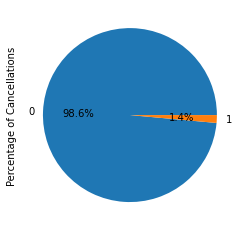

In [34]:
#Checking distribution of our response variables.
#The below code was altered from: https://wellsr.com/python/upsampling-and-downsampling-imbalanced-data-in-python/

print(df_air["cancelled"].value_counts())

df_air.groupby('cancelled').size().plot(kind='pie',
                                       y = "cancelld",
                                       label = "Percentage of Cancellations",
                                       autopct='%1.1f%%');

0    8412
1    4102
Name: is_delay, dtype: int64


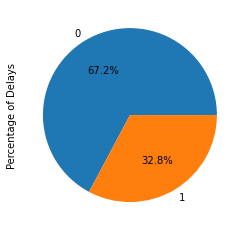

In [35]:
#Checking distribution of our response variables.
#The below code was altered from: https://wellsr.com/python/upsampling-and-downsampling-imbalanced-data-in-python/

print(df_air["is_delay"].value_counts())

df_air.groupby('is_delay').size().plot(kind='pie',
                                       y = "is_delay",
                                       label = "Percentage of Delays",
                                       autopct='%1.1f%%');

***
# Modeling and Evaluations 1
**Choose and explain your evaluation metrics that you will use (i.e., accuracy, precision, recall, F-measure, or any metric we have discussed).** <br>

> Two model evaluation metrics were chosen for this lab. AUC was used for Task One, and F1-score was used for Task Two.

**Why are the measure(s) appropriate for analyzing the results of your modeling? Give a detailed explanation backing up any assertions.** <br>

> The team used AUC to evaluate models built for Task One (predicting flight delays). The team believes AUC fits our data set well due to its ability to distinguish between positive and negative classes. Distinguishing between positive and negative classes is important in our project, because delays directly impact an airline’s bottom line.

> The team used F1-score to evaluate models built for Task Two (predicting flight cancellations). F1-score was chosen as an appropriate metric because we did not find recall or precision to be more important than the other. The team believes both precision and recall are important for predicting flight cancellations because we want to ensure that our model is performing accurately against both our train and test sets.

***
# Modeling and Evaluations 2 
**Choose the method you will use for dividing your data into training and testing splits (i.e., are you using Stratified 10-fold cross validation? Why?)** <br>
> The method we decided to use to create our training and testing data sets was stratified 10-fold cross validation. This was chosen due to industry standards and therefore we found this most appropriate. Stratification also keeps the same proprotion of the feature in interest as in the original data set.
    

> Due to extensive runtime and processing issues, for GridSearchCV, we used a 3-fold cross validation set. 

> We used an 80/20 train/test split for modeling as this is a standard in the industry.
   

In [36]:
#Specififying Stratified Kfold for cv.
skfcv = StratifiedKFold(n_splits=10)

> Creating Test and Train Split for Task 1 (Predicting Delay)

In [37]:
#remove target variable and column target was created from training data set
target_delay_cols = ['is_delay','departure_delay']
feature_delay_cols = final_df.loc[:, ~final_df.columns.isin(target_delay_cols)].columns
X_delay = final_df[feature_delay_cols] # Features
y_delay = final_df.is_delay # Target variable

In [38]:
#split original dataset into features and target variable
X_delay_train,X_delay_test,y_delay_train,y_delay_test=train_test_split(X_delay,y_delay,test_size=0.20,random_state=0)

In [39]:
#imputing 0 into NaN values for logistic regression after OHE
X_delay_train = X_delay_train.fillna(0)
X_delay_test = X_delay_test.fillna(0)
y_delay_train = y_delay_train.fillna(0)
y_delay_test = y_delay_test.fillna(0)

In [40]:
#checking shape of data
print('X_delay_train shape: ',X_delay_train.shape,'\n')
print('X_delay_test shape: ',X_delay_test.shape,'\n')
print('y_delay_train shape: ',y_delay_train.shape,'\n')
print('y_delay_test shape: ',y_delay_test.shape)

X_delay_train shape:  (10011, 1775) 

X_delay_test shape:  (2503, 1775) 

y_delay_train shape:  (10011,) 

y_delay_test shape:  (2503,)


> Creating Test and Train Split for Task 2 (Predicting Cancellation)

In [41]:
#remove target variable and column target was created from training data set
target_cancel_cols = ['cancelled','cancellation_reason']
feature_cancel_cols = final_df.loc[:, ~final_df.columns.isin(target_cancel_cols)].columns
X_cancel = final_df[feature_cancel_cols] # Features
y_cancel = final_df.is_delay # Target variable

In [42]:
#split original dataset into features and target variable
X_cancel_train,X_cancel_test,y_cancel_train,y_cancel_test=train_test_split(X_cancel,y_cancel,test_size=0.20,random_state=0)

In [43]:
#imputing 0 into NaN values for logistic regression after OHE
X_cancel_train = X_cancel_train.fillna(0)
X_cancel_test = X_cancel_test.fillna(0)
y_cancel_train = y_cancel_train.fillna(0)
y_cancel_test = y_cancel_test.fillna(0)

In [44]:
#checking shape of data
print('X_cancel_train shape: ',X_cancel_train.shape,'\n')
print('X_cancel_test shape: ',X_cancel_test.shape,'\n')
print('y_cancel_train shape: ',y_cancel_train.shape,'\n')
print('y_cancel_test shape: ',y_cancel_test.shape)

X_cancel_train shape:  (10011, 1776) 

X_cancel_test shape:  (2503, 1776) 

y_cancel_train shape:  (10011,) 

y_cancel_test shape:  (2503,)


***
# Modeling and Evaluations 3 
Create three different classification/regression models (e.g., random forest, KNN, and SVM).
> We have selected a logistic regression model to set our baseline for evaluation, random forests and KNN
    
Two modeling techniques must be new (but the third could be SVM or logistic regression).
Adjust PARAMETERS as appropriate to increase generalization performance using your chosen metric.

The perameters we adjusted and why in each model were: <br>

**Logistic Regression:** <br>
1) l1_ratio=1
2) penalty='elasticnet'
3) solver='saga'
4) tol=0.1

**Random Forest:** <br>
1) criterion='entropy'
2) max_features='auto'
3) n_estimators=100

**KNN:** <br>
1) n_neighbors = 17
2) weights ='distance'

### Logistic Regression:
To simplify the code and useability of the model, we used a pipeline function from sklearn to standardize (using StandarScaler), run the data through PCA and then finally a logistic regession model using the PCA output.
***

### Logistic Regression: Task 1

In [204]:
#https://towardsdatascience.com/getting-the-most-out-of-scikit-learn-pipelines-c2afc4410f1a

# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
pca = PCA()
# Define a Standard Scaler to normalize inputs
scaler = StandardScaler()

tolerance = 0.1
l1ratio = 1
rs = 0

# Scale -> PCA -> LR 
logistic = LogisticRegression(solver = 'saga',
                                random_state = rs,
                                penalty ='elasticnet',
                                l1_ratio = l1ratio,
                                tol = tolerance)

pipe = Pipeline(steps=[("scaler", scaler),
                       ("pca", pca),
                       ("logistic", logistic)]
               )

pipe.fit(X_delay_train,y_delay_train)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA()),
                ('logistic',
                 LogisticRegression(l1_ratio=1, penalty='elasticnet',
                                    random_state=0, solver='saga', tol=0.1))])

In [48]:
#predict
#predict
y_delay_pred= cross_val_predict(pipe, X_delay_test, y_delay_test, cv=skfcv)

In [49]:
#Metrics
print("Accuracy:",metrics.accuracy_score(y_delay_test, y_delay_pred))
print("Precision:",metrics.precision_score(y_delay_test, y_delay_pred))
print("Recall:",metrics.recall_score(y_delay_test, y_delay_pred))

Accuracy: 0.7810627247303236
Precision: 0.8287292817679558
Recall: 0.3816793893129771


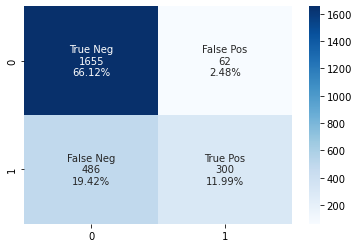

In [50]:
lr_delay_matrix = confusion_matrix(y_delay_test, y_delay_pred)


lr_delay_group_names = ['True Neg','False Pos','False Neg','True Pos']

lr_delay_group_counts = ["{0:0.0f}".format(value) for value in
                lr_delay_matrix.flatten()]

lr_delay_group_percentages = ["{0:.2%}".format(value) for value in
                     lr_delay_matrix.flatten()/np.sum(lr_delay_matrix)]

lr_delay_labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(lr_delay_group_names,lr_delay_group_counts,lr_delay_group_percentages)]

lr_delay_labels = np.asarray(lr_delay_labels).reshape(2,2)

sns.heatmap(lr_delay_matrix, annot=lr_delay_labels, fmt='', cmap='Blues');

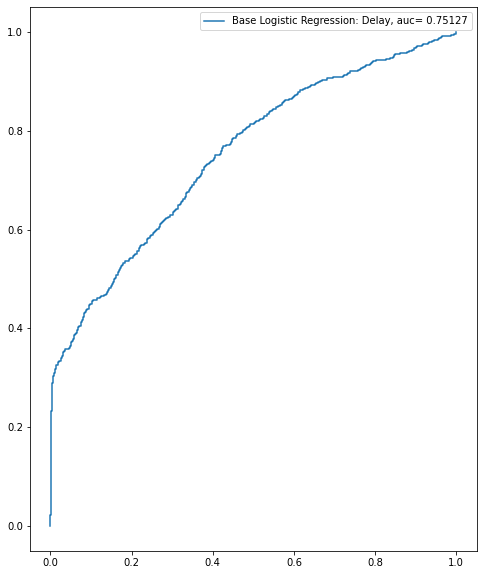

In [171]:
#ROC Curve
lr_delay_ypred_proba = pipe.predict_proba(X_delay_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_delay_test,  lr_delay_ypred_proba)
lr_cancel_auc = metrics.roc_auc_score(y_delay_test, lr_delay_ypred_proba)
plt.plot(fpr,tpr,label="Base Logistic Regression: Delay, auc= "+str(round(lr_cancel_auc,5)))
plt.legend(loc=0)
plt.show();

Text(0.5, 1.0, 'Coefficients in the Logistic Regression Model for Delays')

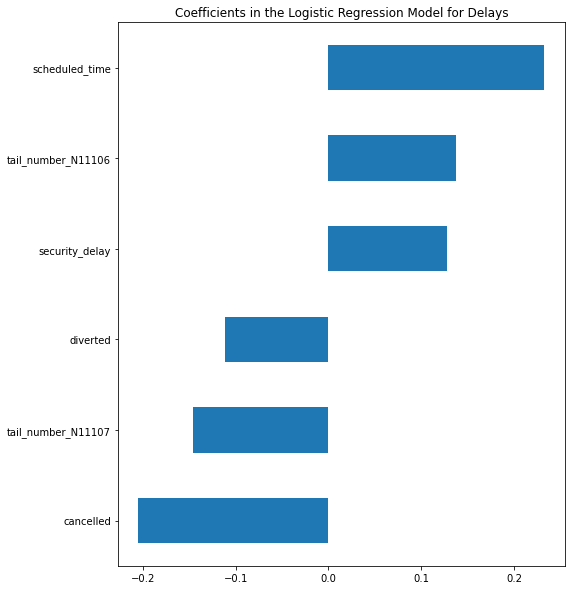

In [206]:
delay_coef = pd.Series(pipe.named_steps['logistic'].coef_[0], index = X_delay_train.columns)
delay_imp_coef = pd.concat([delay_coef.sort_values().head(3),
                     delay_coef.sort_values().tail(3)])

matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
delay_imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Logistic Regression Model for Delays")

### Logistic Regression: Task 2

In [199]:

#https://towardsdatascience.com/getting-the-most-out-of-scikit-learn-pipelines-c2afc4410f1a

# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
pca = PCA()
# Define a Standard Scaler to normalize inputs
scaler = StandardScaler()

tolerance = 0.1
l1ratio = 1
rs = 0

# Scale -> PCA -> LR 
logistic = LogisticRegression(solver = 'saga',
                                random_state = rs,
                                penalty ='elasticnet',
                                l1_ratio = l1ratio,
                                tol = tolerance)

pipe2 = Pipeline(steps=[("scaler", scaler),
                       ("pca", pca),
                       ("logistic", logistic)]
               )

pipe2.fit(X_cancel_train,y_cancel_train)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA()),
                ('logistic',
                 LogisticRegression(l1_ratio=1, penalty='elasticnet',
                                    random_state=0, solver='saga', tol=0.1))])

In [165]:
#predict
y_cancel_pred= cross_val_predict(pipe2, X_cancel_test, y_cancel_test, cv=skfcv)

In [ ]:
feature_importance = pd.DataFrame(feature_names, columns = ["feature"])
feature_importance["importance"] = pow(math.e, w)
feature_importance = feature_importance.sort_values(by = ["importance"], ascending=False)
from sklearn.linear_model import LogisticRegression
ax = feature_importance.plot.barh(x='feature', y='importance')
plt.show()

In [166]:
#Code adapted from: https://medium.com/@hjhuney/implementing-a-random-forest-classification-model-in-python-583891c99652
print("=== Confusion Matrix ===")
print(confusion_matrix(y_cancel_test, y_cancel_pred))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_cancel_test, y_cancel_pred))

=== Confusion Matrix ===
[[1716    1]
 [   1  785]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1717
           1       1.00      1.00      1.00       786

    accuracy                           1.00      2503
   macro avg       1.00      1.00      1.00      2503
weighted avg       1.00      1.00      1.00      2503



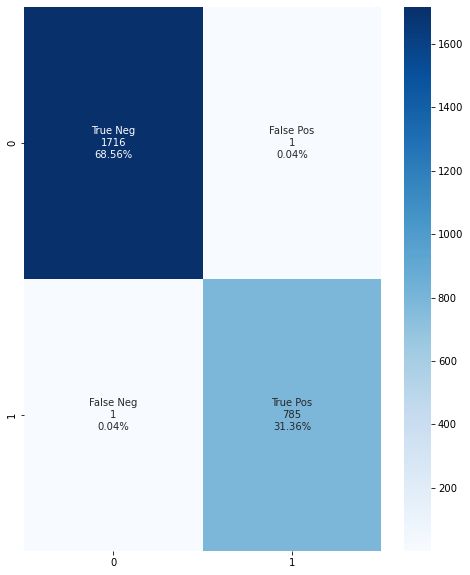

In [167]:
lr_cancel_matrix = confusion_matrix(y_cancel_test, y_cancel_pred)


lr_cancel_group_names = ['True Neg','False Pos','False Neg','True Pos']

lr_cancel_group_counts = ["{0:0.0f}".format(value) for value in
                lr_cancel_matrix.flatten()]

lr_cancel_group_percentages = ["{0:.2%}".format(value) for value in
                     lr_cancel_matrix.flatten()/np.sum(lr_cancel_matrix)]

lr_cancel_labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(lr_cancel_group_names,lr_cancel_group_counts,lr_cancel_group_percentages)]

lr_cancel_labels = np.asarray(lr_cancel_labels).reshape(2,2)

sns.heatmap(lr_cancel_matrix, annot=lr_cancel_labels, fmt='', cmap='Blues');

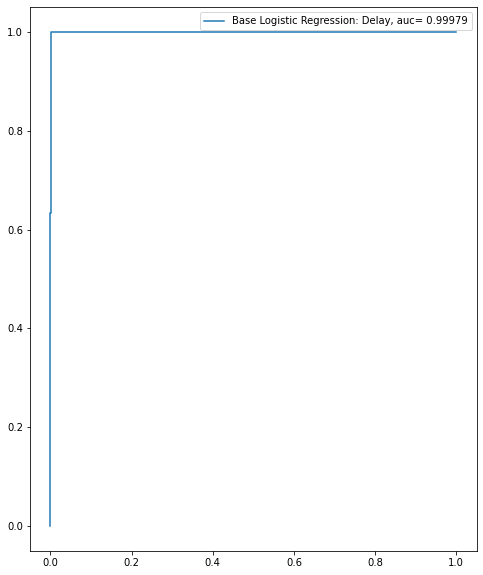

In [170]:
#ROC Curve
lr_cancel_ypred_proba = pipe2.predict_proba(X_cancel_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_cancel_test,  lr_cancel_ypred_proba)
lr_cancel_auc = metrics.roc_auc_score(y_cancel_test, lr_cancel_ypred_proba)
plt.plot(fpr,tpr,label="Base Logistic Regression: Delay, auc= "+str(round(lr_cancel_auc,5)))
plt.legend(loc=0)
plt.show();

Text(0.5, 1.0, 'Coefficients in the Logistic Regression Model for Cancelations')

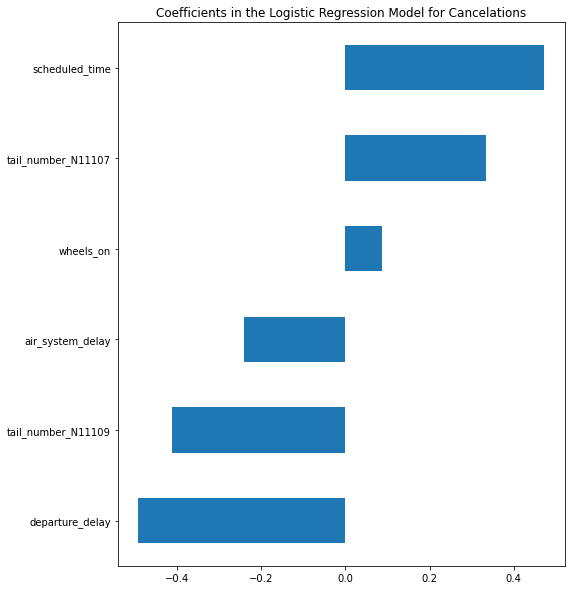

In [202]:
coef = pd.Series(pipe2.named_steps['logistic'].coef_[0], index = X_cancel_train.columns)
imp_coef = pd.concat([coef.sort_values().head(3),
                     coef.sort_values().tail(3)])

matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Logistic Regression Model for Cancelations")

***
## Classification Model #2
### Random Forest:
***

### Random Forest: Task 1

In [60]:
#Creating our random forest pipeline.
rf = RandomForestClassifier(n_estimators=100, random_state=0)

In [61]:
#Fitting random forest model on training data.
rf.fit(X_delay_train, y_delay_train)

RandomForestClassifier(random_state=0)

In [62]:
#Predicting on our test set.
y_pred_rf = rf.predict(X_delay_test)

In [63]:
#Code adapted from: https://medium.com/@hjhuney/implementing-a-random-forest-classification-model-in-python-583891c99652
rfc_cv_score = cross_val_score(rf, X_delay_test, y_delay_test, cv=skfcv, scoring='accuracy')

In [64]:
#Code adapted from: https://medium.com/@hjhuney/implementing-a-random-forest-classification-model-in-python-583891c99652
print("=== Confusion Matrix ===")
print(confusion_matrix(y_delay_test, y_pred_rf))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_delay_test, y_pred_rf))
print("=== All AUC Scores ===")
print(rfc_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())

=== Confusion Matrix ===
[[1660   57]
 [ 330  456]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.83      0.97      0.90      1717
           1       0.89      0.58      0.70       786

    accuracy                           0.85      2503
   macro avg       0.86      0.77      0.80      2503
weighted avg       0.85      0.85      0.83      2503

=== All AUC Scores ===
[0.812749   0.83266932 0.84063745 0.832      0.856      0.852
 0.808      0.84       0.8        0.832     ]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.830605577689243


### Random Forest Grid Search: Task 1

In [65]:
#Task 1 Grid Search parameters: 
#Specifying the number of trees in random forest:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 10)]
#Specifying criterion for each split:
criterion = ['gini','entropy']
#Specifying the number of features to consider at every split:
max_features = ['auto','sqrt', 'log2','none']

In [66]:
#Creating pipeline for GridSearch:
#Creating and printing my random grid with parameters defined above:
param_grid = {'n_estimators': n_estimators,
               'criterion': criterion,
               'max_features': max_features}
print(param_grid)

{'n_estimators': [100, 144, 188, 233, 277, 322, 366, 411, 455, 500], 'criterion': ['gini', 'entropy'], 'max_features': ['auto', 'sqrt', 'log2', 'none']}


In [67]:
#Base RF model used to tune:
rf = RandomForestClassifier(random_state=0)

In [68]:
#Throwing RF through a GridSearch:
rf_random = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, verbose=1)

In [69]:
%%time
#Fiting the random search model on our training data:
rf_random.fit(X_delay_train, y_delay_train)

Fitting 3 folds for each of 80 candidates, totalling 240 fits


/Users/allen/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
60 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/allen/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/allen/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 450, in fit
    trees = Parallel(
  File "/Users/allen/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  Fi

CPU times: user 19min 50s, sys: 2.43 s, total: 19min 52s
Wall time: 25min 33s


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=0),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['auto', 'sqrt', 'log2', 'none'],
                         'n_estimators': [100, 144, 188, 233, 277, 322, 366,
                                          411, 455, 500]},
             verbose=1)

In [70]:
#Viewing the best parameters selected from GridSearch:
rf_random.best_params_

{'criterion': 'entropy', 'max_features': 'auto', 'n_estimators': 100}

### Re-Fitting Random Forest with GridSearch Parameters: Task 1

In [71]:
#Defining RF model with best parameters from GridSearch:
rf_gs = RandomForestClassifier(criterion='entropy',max_features='auto',n_estimators=100,random_state=0) #INSERT IN BEST GRIDSEARCH PARAMS

In [72]:
#Re-fitting RF model with GS parameters and SKFCV on training data:
#Code adapted from: https://medium.com/@hjhuney/implementing-a-random-forest-classification-model-in-python-583891c99652
rfc_cv_score_train = cross_val_score(rf_gs, X_delay_train, y_delay_train, cv=skfcv, scoring='accuracy')

rf_gs.fit(X_delay_train,y_delay_train)
rf_gs_pred = rf_gs.predict(X_delay_test)

In [73]:
#Viewing performance metrics:
#Code adapted from: https://medium.com/@hjhuney/implementing-a-random-forest-classification-model-in-python-583891c99652
print("=== Confusion Matrix ===")
print(confusion_matrix(y_delay_test, rf_gs_pred))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_delay_test, rf_gs_pred))
print("=== All AUC Scores ===")
print(rfc_cv_score_train)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score_train.mean())

=== Confusion Matrix ===
[[1665   52]
 [ 336  450]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.83      0.97      0.90      1717
           1       0.90      0.57      0.70       786

    accuracy                           0.84      2503
   macro avg       0.86      0.77      0.80      2503
weighted avg       0.85      0.84      0.83      2503

=== All AUC Scores ===
[0.83133733 0.83816184 0.84315684 0.84215784 0.83716284 0.83116883
 0.84515485 0.82817183 0.81718282 0.83616384]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.8349818843830821


### Feature Importances for GridSearch RF Model: Task 1

In [74]:
importances = rf_gs.feature_importances_

In [75]:
# Getting indices of N = 3 maximum values
x = np.argsort(importances)[::-1][:5]
print("Indices:",x)

# Getting N maximum values
print("Values:",importances[x])

Indices: [12 20  2 10 13]
Values: [0.14371487 0.08693868 0.08564488 0.08370328 0.08020031]


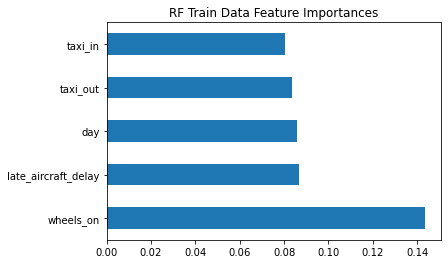

In [76]:
plt.title('RF Train Data Feature Importances')
(pd.Series(rf_gs.feature_importances_, index=X_delay_test.columns)
   .nlargest(5)
   .plot(kind='barh')) ;

### Visualizing task one RF GridSearch Model: Task 1

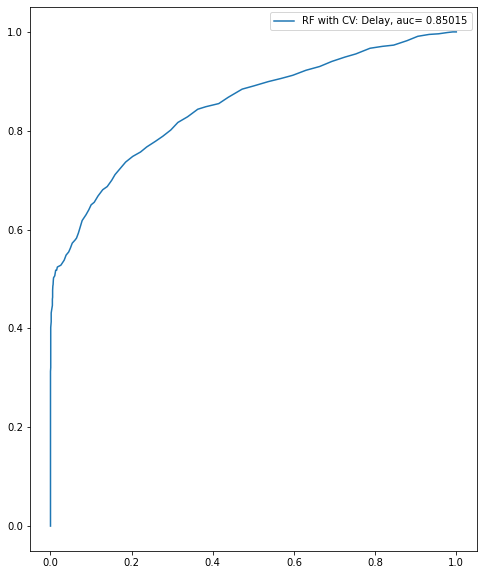

In [174]:
#ROC Curve
rf_delay_ypred_proba = rf_gs.predict_proba(X_delay_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_delay_test,  rf_delay_ypred_proba)
rf_delay_auc = metrics.roc_auc_score(y_delay_test, rf_delay_ypred_proba)
plt.plot(fpr,tpr,label="RF with CV: Delay, auc= "+str(round(rf_delay_auc,5)))
plt.legend(loc=0)
plt.show();

### Random Forest: Task 2

In [78]:
#Creating our random forest pipeline.
rf_cancel = RandomForestClassifier(random_state=0)

In [79]:
#Fitting random forest model on training data.
rf_cancel.fit(X_cancel_train, y_cancel_train)

RandomForestClassifier(random_state=0)

In [80]:
#Predicting on our test set.
y_pred_rf = rf_cancel.predict(X_cancel_test)

In [81]:
#Running RF model through CV:
#Code adapted from: https://medium.com/@hjhuney/implementing-a-random-forest-classification-model-in-python-583891c99652
rfc_cv_score2 = cross_val_score(rf_cancel, X_cancel_test, y_cancel_test, cv=skfcv, scoring='accuracy')

In [82]:
#Code adapted from: https://medium.com/@hjhuney/implementing-a-random-forest-classification-model-in-python-583891c99652
print("=== Confusion Matrix ===")
print(confusion_matrix(y_cancel_test, y_pred_rf))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_cancel_test, y_pred_rf))
print("=== All AUC Scores ===")
print(rfc_cv_score2)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score2.mean())

=== Confusion Matrix ===
[[1717    0]
 [   0  786]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1717
           1       1.00      1.00      1.00       786

    accuracy                           1.00      2503
   macro avg       1.00      1.00      1.00      2503
weighted avg       1.00      1.00      1.00      2503

=== All AUC Scores ===
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  1.0


### Feature Importances for GridSearch RF Model: Task 2

In [83]:
importances = rf_cancel.feature_importances_

In [84]:
# Getting indices of N = 5 maximum values
x = np.argsort(importances)[::-1][:5]
print("Indices:",x)

# Getting N maximum values
print("Values:",importances[x])

Indices: [10 22 19 20 13]
Values: [0.38372538 0.34638217 0.05040314 0.0488084  0.0312858 ]


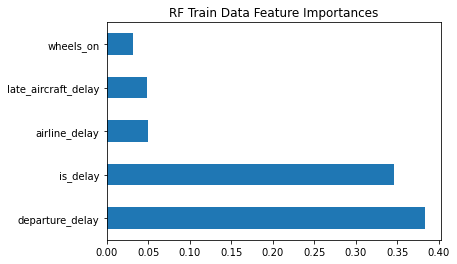

In [85]:
plt.title('RF Train Data Feature Importances')
(pd.Series(rf_cancel.feature_importances_, index=X_cancel_test.columns)
   .nlargest(5)
   .plot(kind='barh')) ;

### Visualizing Model: Task 2

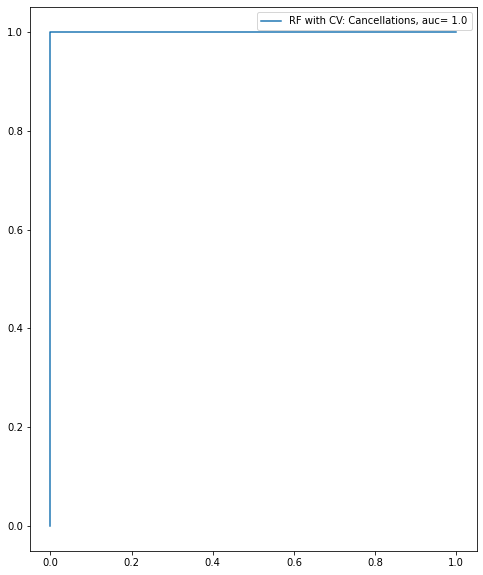

In [177]:
#ROC Curve
rf_cancel_ypred_proba = rf_cancel.predict_proba(X_cancel_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_delay_test,  rf_cancel_ypred_proba)
rf_cancel_auc = metrics.roc_auc_score(y_cancel_test, rf_cancel_ypred_proba)
plt.plot(fpr,tpr,label="RF with CV: Cancellations, auc= "+str(round(rf_cancel_auc,5)))
plt.legend(loc=0)
plt.show();

***
## Classification Model #2
### KNN
***
### KNN: Task 1

In [184]:
scaler_knn = RobustScaler()

In [185]:
%%time
knn_delay = KNeighborsClassifier(n_neighbors = 17, weights='distance')

pipe_knn_delay = Pipeline(steps=[("scaler", scaler_knn),
                       ("KNN", knn_delay)])

pipe_knn_delay.fit(X_delay_train,y_delay_train)

y_pred_pipe_knn_delay = pipe_knn_delay.predict(X_delay_test)

pipe_knn_cv_score_delay = cross_val_score(pipe_knn_delay, X_delay_test, y_delay_test, cv=skfcv, scoring='accuracy')

CPU times: user 11.5 s, sys: 1.75 s, total: 13.2 s
Wall time: 3.29 s


In [186]:
print("=== Confusion Matrix ===")
print(confusion_matrix(y_delay_test, y_pred_pipe_knn_delay))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_delay_test, y_pred_pipe_knn_delay))
print("=== All AUC Scores ===")
print(pipe_knn_cv_score_delay)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - KNN: ", pipe_knn_cv_score_delay.mean())

=== Confusion Matrix ===
[[1663   54]
 [ 393  393]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.81      0.97      0.88      1717
           1       0.88      0.50      0.64       786

    accuracy                           0.82      2503
   macro avg       0.84      0.73      0.76      2503
weighted avg       0.83      0.82      0.80      2503

=== All AUC Scores ===
[0.80079681 0.82868526 0.8247012  0.816      0.852      0.852
 0.816      0.82       0.808      0.84      ]


=== Mean AUC Score ===
Mean AUC Score - KNN:  0.8258183266932271


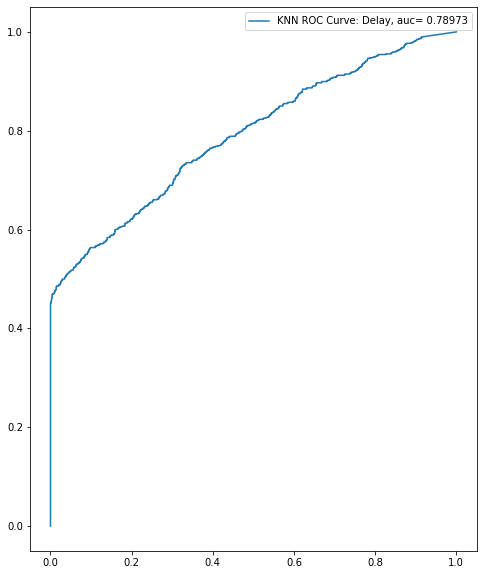

In [187]:
#ROC Curve
knn_delay_ypred_proba = pipe_knn_delay.predict_proba(X_delay_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_delay_test, knn_delay_ypred_proba)
knn_delay_auc = metrics.roc_auc_score(y_delay_test, knn_delay_ypred_proba)
plt.plot(fpr,tpr,label="KNN ROC Curve: Delay, auc= "+str(round(knn_delay_auc,5)))
plt.legend(loc=0)
plt.show();

### KNN: Task 2

In [155]:
%%time
knn_cancel = KNeighborsClassifier(n_neighbors = 17, weights='distance')

pipe_knn_cancel = Pipeline(steps=[("scaler", scaler_knn),
                       ("KNN", knn_cancel)])

pipe_knn_cancel.fit(X_cancel_train,y_cancel_train)

y_pred_pipe_knn_cancel = pipe_knn_cancel.predict(X_cancel_test)

pipe_knn_cv_score_cancel = cross_val_score(pipe_knn_cancel, X_cancel_test, y_cancel_test, cv=skfcv, scoring='accuracy')


CPU times: user 11.3 s, sys: 2 s, total: 13.3 s
Wall time: 3.43 s


In [156]:
print("=== Confusion Matrix ===")
print(confusion_matrix(y_cancel_test, y_pred_pipe_knn_cancel))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_cancel_test, y_pred_pipe_knn_cancel))
print("=== All AUC Scores ===")
print(pipe_knn_cv_score_cancel)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - KNN: ", pipe_knn_cv_score_cancel.mean())

=== Confusion Matrix ===
[[1712    5]
 [  42  744]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1717
           1       0.99      0.95      0.97       786

    accuracy                           0.98      2503
   macro avg       0.98      0.97      0.98      2503
weighted avg       0.98      0.98      0.98      2503

=== All AUC Scores ===
[0.96812749 0.9561753  0.97609562 0.964      0.976      0.948
 0.936      0.952      0.952      0.936     ]


=== Mean AUC Score ===
Mean AUC Score - KNN:  0.9564398406374501


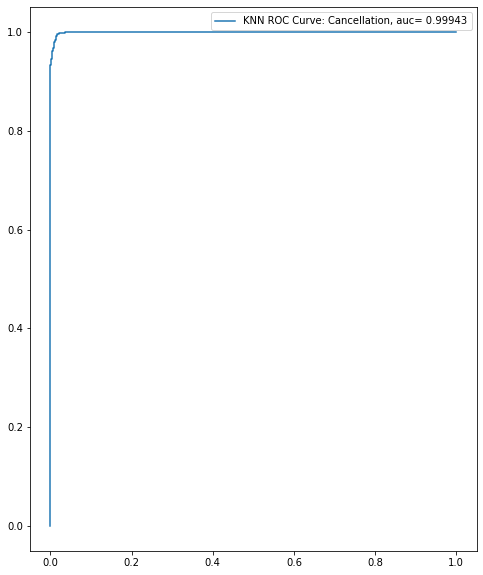

In [181]:
#ROC Curve
knn_cancel_ypred_proba = pipe_knn_cancel.predict_proba(X_cancel_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_cancel_test, knn_cancel_ypred_proba)
knn_cancel_auc = metrics.roc_auc_score(y_cancel_test, knn_cancel_ypred_proba)
plt.plot(fpr,tpr,label="KNN ROC Curve: Cancellation, auc= "+str(round(knn_cancel_auc,5)))
plt.legend(loc=0)
plt.show();

***
# Modeling and Evaluations 4
Analyze the results using your chosen method of evaluation. Use 
visualizations of the results to bolster the analysis. Explain any visuals and analyze why 
they are interesting to someone that might use this model

#### **Logistic Regression**
***

**Task 1(Predicting Flight Delays):**

> The logistic regression model for flight delays returned an AUC score of .75. It is slightly lower than the AUC .8 threshold we were looking for but with the unbalanced data this was the best option available. This is a fair score of discrimination and gives a more holistic analysis of our model rather using only Accuracy.

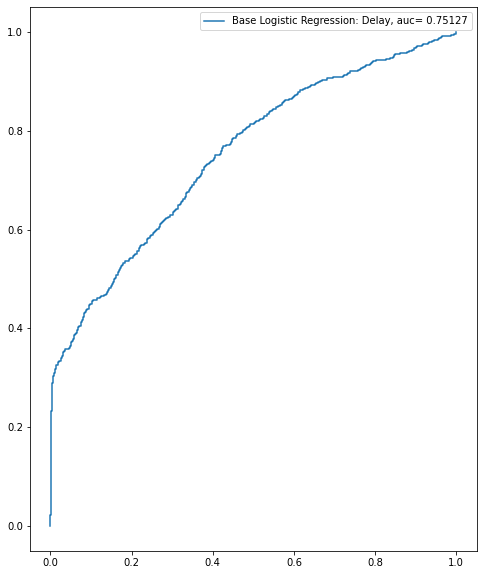

In [172]:
#ROC Curve
lr_delay_ypred_proba = pipe.predict_proba(X_delay_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_delay_test,  lr_delay_ypred_proba)
lr_cancel_auc = metrics.roc_auc_score(y_delay_test, lr_delay_ypred_proba)
plt.plot(fpr,tpr,label="Base Logistic Regression: Delay, auc= "+str(round(lr_cancel_auc,5)))
plt.legend(loc=0)
plt.show();

**Task 2(Predicting Flight Cancellations):**

> The logistic regression model returned an F1 score of .999 for flight cancellations. This is telling us the model does a great job not making false positive or false negative classifications. In the model we ran we returned only a 1 fast positive out of the enter set. F1 was there for chosen over precision and recall because we did not find either to be more important or significant than the other.

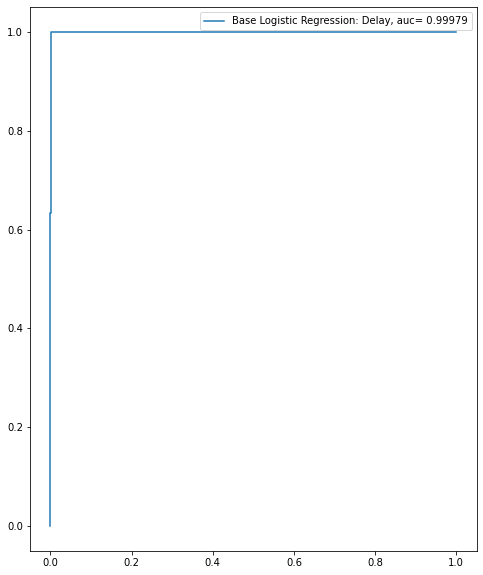

In [173]:
#ROC Curve
lr_cancel_ypred_proba = pipe2.predict_proba(X_cancel_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_cancel_test,  lr_cancel_ypred_proba)
lr_cancel_auc = metrics.roc_auc_score(y_cancel_test, lr_cancel_ypred_proba)
plt.plot(fpr,tpr,label="Base Logistic Regression: Delay, auc= "+str(round(lr_cancel_auc,5)))
plt.legend(loc=0)
plt.show();

#### **Random Forest**
***

**NOTE:** 

> The team recognizes that the model metrics for our random forest models are high (AUC = .83948 and F1 = 1). Given additional time, the team would work on pruning trees to refine the models and ensure that they are not overfit.

> 3-fold cross validation was used for our task one GridSearch due to limited processing power. After performing GridSearch, 10-fold stratified cross validation was used to safeguard against class imbalances and to ensure that each fold was equally represented. Stratified K-fold cross validation was deemed appropriate for our data as our data set has 5,817,010 records and class imbalance is present in both our response variables.

**Task 1(Predicting Flight Delays):**

>  

>The team created 2 random forest models for task one. One model was a base random forest model with no parameter tuning. The second model was tuned using GridSearch to determine the optimal parameters for: criterion, max_features, and n_estimators. Below is the AUC metric for each model:

>AUC was used to evaluate these models because distinguishing between positive and negative classes is important in our project, because delays directly impact an airline’s bottom line.

1) Base RF Model:
> AUC: 0.83060

2) RF Model After GridSearch:
> AUC: 0.83498

**Best RF Model:**
> From the AUC metrics above, our random forest GridSearch model performed better. This is to be expected as GridSearch tuned random forest on the following parameters for us: criterion, max_features, and n_estimators.

**Visualizations Created for Best RF Model:**
> To visualize model performance the team created a confusion matrix and an ROC curve. The confusion matrix showed 1665
True Negatives, 52 False Positives, 336 False Negatives and 44 True Positives. This resulted in a AUC score of 0.83498.


In [117]:
#Viewing performance metrics:
#Code adapted from: https://medium.com/@hjhuney/implementing-a-random-forest-classification-model-in-python-583891c99652
print("=== Confusion Matrix ===")
print(confusion_matrix(y_delay_test, rf_gs_pred))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_delay_test, rf_gs_pred))
print("=== All AUC Scores ===")
print(rfc_cv_score_train)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score_train.mean())

=== Confusion Matrix ===
[[1665   52]
 [ 336  450]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.83      0.97      0.90      1717
           1       0.90      0.57      0.70       786

    accuracy                           0.84      2503
   macro avg       0.86      0.77      0.80      2503
weighted avg       0.85      0.84      0.83      2503

=== All AUC Scores ===
[0.83133733 0.83816184 0.84315684 0.84215784 0.83716284 0.83116883
 0.84515485 0.82817183 0.81718282 0.83616384]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.8349818843830821


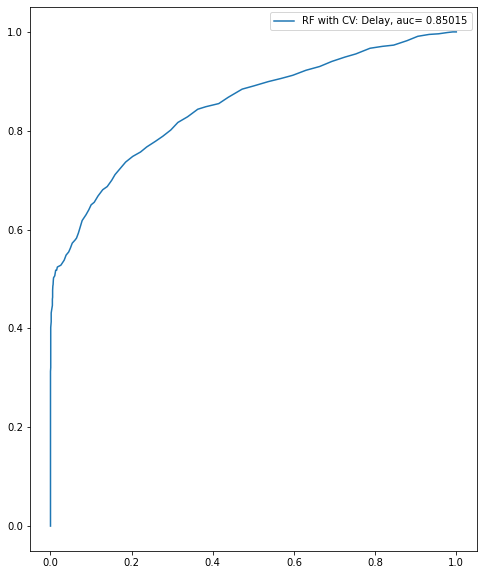

In [175]:
#ROC Curve
rf_delay_ypred_proba = rf_gs.predict_proba(X_delay_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_delay_test,  rf_delay_ypred_proba)
rf_delay_auc = metrics.roc_auc_score(y_delay_test, rf_delay_ypred_proba)
plt.plot(fpr,tpr,label="RF with CV: Delay, auc= "+str(round(rf_delay_auc,5)))
plt.legend(loc=0)
plt.show();

**Task Two (Predicting Flight Cancellations):**

> 

> The team created 1 random forest model for task two. Only one model was fit as the base model had perfect performance. F1 was the model metric selected by our team to evaluate performance because the team believes both precision and recall are important for predicting flight cancellations.

1) RF Model:
> F1: 1.0

>Recognizing that an F1 score of 1.0 could be an indication of overfitting, the team decided to run our model using data from the DFW airport. A random forest model built on this data had an F1 score of 1.0 as well. The team is not concerned about this high accuracy because as evidence in our confusion matrix (shown below), the model accurately classified 1717 not cancelled flights and 786 cancelled flights.

**Visualizations Created for RF Model:**
>To visualize the results from our random forest model, the team created a confusion matrix and an ROC curve. Our confusion matrix showed a perfect classification with 0 false positives and 0 false negatives identified. Our ROC curve showed a perfect score as well at (1.0).


In [119]:
#Code adapted from: https://medium.com/@hjhuney/implementing-a-random-forest-classification-model-in-python-583891c99652
print("=== Confusion Matrix ===")
print(confusion_matrix(y_cancel_test, y_pred_rf))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_cancel_test, y_pred_rf))
print("=== All AUC Scores ===")
print(rfc_cv_score2)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score2.mean())

=== Confusion Matrix ===
[[1717    0]
 [   0  786]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1717
           1       1.00      1.00      1.00       786

    accuracy                           1.00      2503
   macro avg       1.00      1.00      1.00      2503
weighted avg       1.00      1.00      1.00      2503

=== All AUC Scores ===
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  1.0


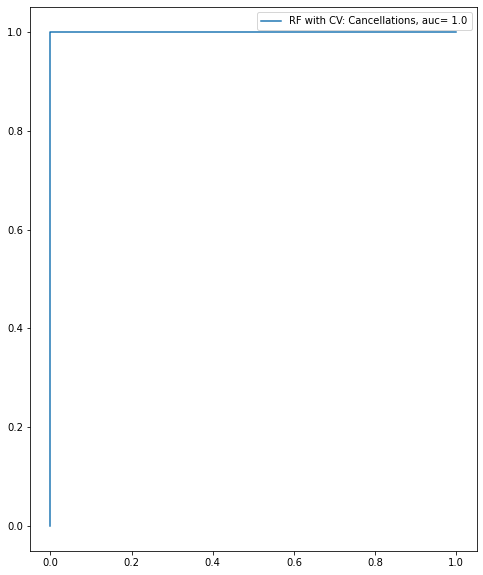

In [178]:
#ROC Curve
rf_cancel_ypred_proba = rf_cancel.predict_proba(X_cancel_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_delay_test,  rf_cancel_ypred_proba)
rf_cancel_auc = metrics.roc_auc_score(y_cancel_test, rf_cancel_ypred_proba)
plt.plot(fpr,tpr,label="RF with CV: Cancellations, auc= "+str(round(rf_cancel_auc,5)))
plt.legend(loc=0)
plt.show();

#### **KNN**
***

**Task 1 (Predicting Flight Delays):**

>The team created our K-Nearest Neighbors model for task 1, by first creating a baseline model and then expanded our model from there. The 1st model was created with the n-neighbor parameter set to 3, the lowest n usable for our data, with the remaining parameters set as the default. From there we switched the weight parameter to “distance” and saw around a 0.1 increase. The team decided to keep the changed weight and moved on the testing algorithm and leaf_size parameters. The team decided that these changes had no substantial effect on AUC and thus returning to adjusting the n-neighbors parameter. Our final AUC is listed below
 
**KNN Model AUC:**
> AUC: 0.8258

> Our team created an ROC curve in order to better visualize the model. The curve indicate that our model is a fairly good classifier for predicting flight delays.

In [149]:
print("=== Confusion Matrix ===")
print(confusion_matrix(y_delay_test, y_pred_pipe_knn_delay))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_delay_test, y_pred_pipe_knn_delay))
print("=== All AUC Scores ===")
print(pipe_knn_cv_score_delay)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - KNN (Delay): ", pipe_knn_cv_score_delay.mean())

=== Confusion Matrix ===
[[1663   54]
 [ 393  393]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.81      0.97      0.88      1717
           1       0.88      0.50      0.64       786

    accuracy                           0.82      2503
   macro avg       0.84      0.73      0.76      2503
weighted avg       0.83      0.82      0.80      2503

=== All AUC Scores ===
[0.80079681 0.82868526 0.8247012  0.816      0.852      0.852
 0.816      0.82       0.808      0.84      ]


=== Mean AUC Score ===
Mean AUC Score - KNN (Delay):  0.8258183266932271


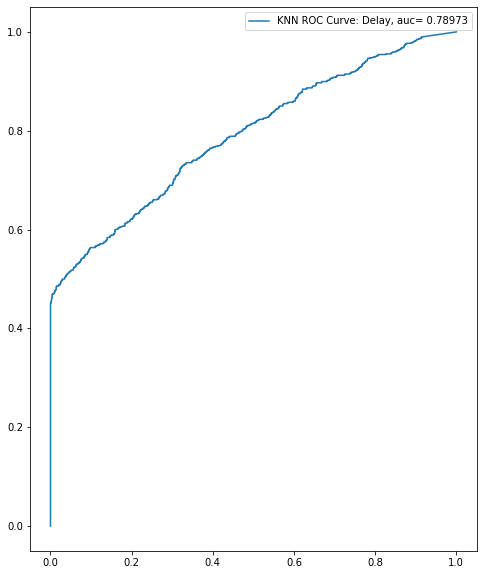

In [188]:
#ROC Curve
knn_delay_ypred_proba = pipe_knn_delay.predict_proba(X_delay_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_delay_test, knn_delay_ypred_proba)
knn_delay_auc = metrics.roc_auc_score(y_delay_test, knn_delay_ypred_proba)
plt.plot(fpr,tpr,label="KNN ROC Curve: Delay, auc= "+str(round(knn_delay_auc,5)))
plt.legend(loc=0)
plt.show();

**Task Two (Predicting Flight Cancellations):**

> The team created 1 K-Nearest Neighbors model for task two. Given the ROC curve we  decided to duplicate the model from task 1. We decided to use F1 as the model metric as the team decided a equal emphasis on precision and recall was needed.

**KNN Model F1:**
> F1: .99

> As indicated by our F1 score and our ROC curve the KNN model appears to be a almost a perfect classifier. Much like our previous algorithm we have decided based on our confusion matrix that this is not a concern. The model does not appear to be over predicting a single outcome, and thus we have decided to keep our model as is.

In [151]:
print("=== Confusion Matrix ===")
print(confusion_matrix(y_cancel_test, y_pred_pipe_knn_cancel))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_cancel_test, y_pred_pipe_knn_cancel))
print("=== All AUC Scores ===")
print(pipe_knn_cv_score_cancel)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - KNN (cencal): ", pipe_knn_cv_score_cancel.mean())

=== Confusion Matrix ===
[[1712    5]
 [  42  744]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1717
           1       0.99      0.95      0.97       786

    accuracy                           0.98      2503
   macro avg       0.98      0.97      0.98      2503
weighted avg       0.98      0.98      0.98      2503

=== All AUC Scores ===
[0.96812749 0.9561753  0.97609562 0.964      0.976      0.948
 0.936      0.952      0.952      0.936     ]


=== Mean AUC Score ===
Mean AUC Score - KNN (cencal):  0.9564398406374501


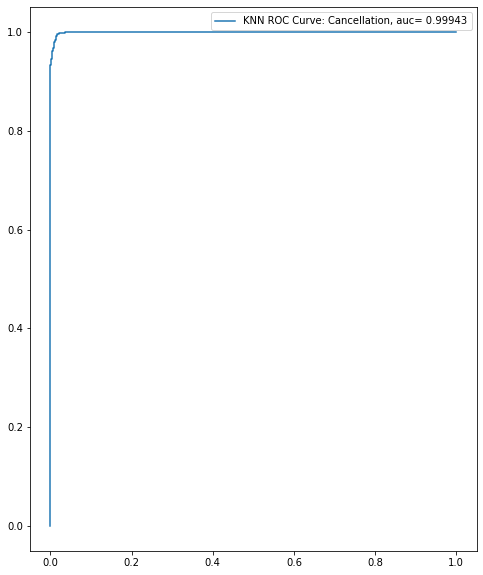

In [182]:
#ROC Curve
knn_cancel_ypred_proba = pipe_knn_cancel.predict_proba(X_cancel_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_cancel_test, knn_cancel_ypred_proba)
knn_cancel_auc = metrics.roc_auc_score(y_cancel_test, knn_cancel_ypred_proba)
plt.plot(fpr,tpr,label="KNN ROC Curve: Cancellation, auc= "+str(round(knn_cancel_auc,5)))
plt.legend(loc=0)
plt.show();

***
# Modeling and Evaluations 5
Discuss the advantages of each model for each classification task, if any. 

> Each model has different hypterparameters that you can tune to create a better classification result. Each base model would perform differently, however once tuned, each model has advantages over eachother. 

**Logistic Regression:**
1) Easy to intrepret
2) Efficient with computation
3) Good with large Data

**Random Forest:**
1) Works well with larger data sets
2) Has more parameters to tune
3) Does not need scaling

**KNN:**
1) Less parameters to tune
2) Does not work as well with large data sets
3) No training period as lazy learner


Is any model better than another? Is the difference significant with 95% confidence?

> To answer the above, we performed a 5x2 CV paired ttest using the MLextend package. Results are shown below for both Task 1 and Task 2 comparing the top performing model using the metric decided (Task1: AUC, Task2: F1).

#### Task 1 T-test:

>Since p-value<α, we reject the null hypothesis and may conclude that the performance of the two algorithms is significantly different. Therefore we can conclude that the Random Forest model is statistically better at predicting delays than KNN.

**RF AUC: 0.83**

**KNN AUC: 0.82**

In [94]:
#http://rasbt.github.io/mlxtend/user_guide/evaluate/paired_ttest_5x2cv/
t, p = paired_ttest_5x2cv(estimator1=rf_gs,
                          estimator2=pipe_knn_delay,
                          X=X_delay_train, y=y_delay_train,
                          random_seed=1)

print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: 5.406
p value: 0.003


#### Task 2 T-test:

>Since p-value=α, we fail to reject the null hypothesis and may conclude that the performance of the two algorithms is not significantly different. This is expected as the F1 score for both the Logistic Regression and Random Forest models are both equal to 1.0.

**RF F1: 1.0**

**LR F1: 1.0**

In [95]:
#http://rasbt.github.io/mlxtend/user_guide/evaluate/paired_ttest_5x2cv/
t, p = paired_ttest_5x2cv(estimator1=pipe2,
                          estimator2=rf_cancel,
                          X=X_cancel_train, y=y_cancel_train,
                          random_seed=1)

print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: 0.000
p value: 1.000


***
# Modeling and Evaluations 6
Which attributes from your analysis are most important? Use proper 
methods discussed in class to evaluate the importance of different attributes. Discuss 
the results and hypothesize about why certain attributes are more important than others 
for a given classification task

#### **Logistic Regression:**
***

**Task One (Predicting Flight Delays):**

1) scheduled_time
2) cancelled
3) tail_number_N11107
4) tail_number_N11106
5) security_delay
6) diverted

The top 6 attributes selected as the most important features make previous assumptions and real world experiences. `schedule_time` was the most important of the features for delays as different times of the day were more like to experience delays. This was in turn caused by a slinking effect, flights delayed earlier in the day would effect flights later in the day. `cancelled` was the second most important as this is essentially an indefinite delay. Two flights came up as the next set of features, this could be tied to a bad track record of timeliness caused by operational issues. `security_delay` came in as the 5th most important and could have several causes and an undefined range of time delay. `diverted` came up as the last feature which is an unexpected change to flight plan and usually not for the better.

Text(0.5, 1.0, 'Coefficients in the Logistic Regression Model for Delays')

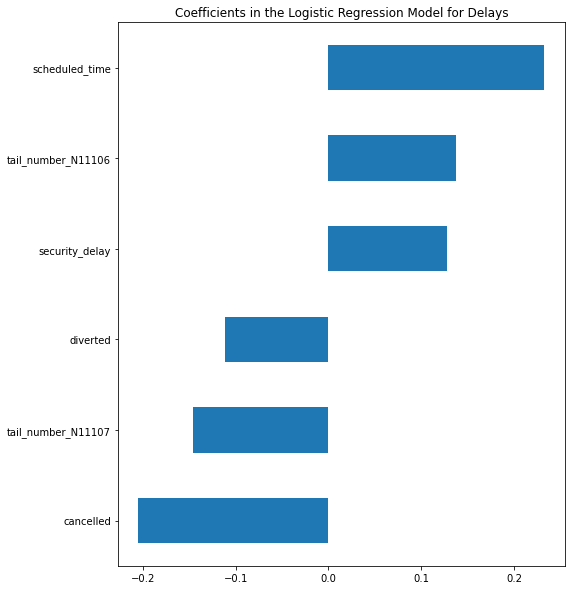

In [207]:
delay_coef = pd.Series(pipe.named_steps['logistic'].coef_[0], index = X_delay_train.columns)
delay_imp_coef = pd.concat([delay_coef.sort_values().head(3),
                     delay_coef.sort_values().tail(3)])

matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
delay_imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Logistic Regression Model for Delays")

**Task Two (Predicting Flight Cancellations):**

1) departure_delay
2) scheduled_time
3) tail_number_N11109
4) tail_number_N11107
5) air_system_delay
6) wheels_on


The top 6 attributes that are most important to the Logistic Regression model do not come as a surprise. With `departure_delay` being the most indicitive of a cancellation. This is due to a higher chance of being cancelled if your flight is already delayed and why `air_system_delay` is also a top 6 attribute in the logistic regression model. `scheduled_time`, just like in the delay prediction, allows for more issues in previous flights for the same aircraft and therefore can be a telling factor on if a flight will be delayed. 

Text(0.5, 1.0, 'Coefficients in the Logistic Regression Model for Cancelations')

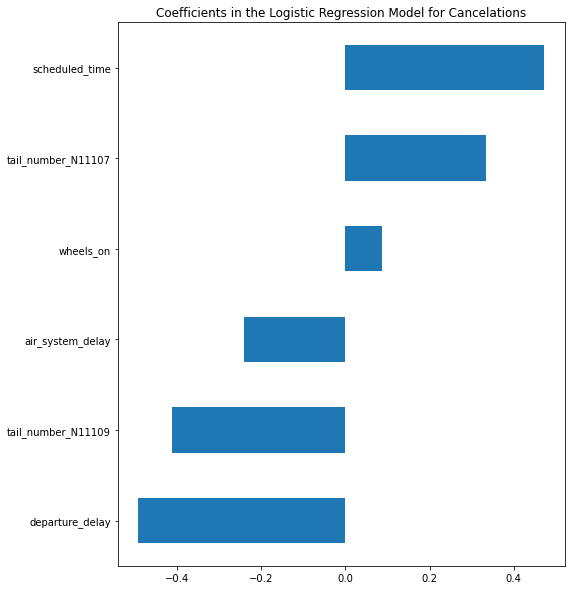

In [208]:
coef = pd.Series(pipe2.named_steps['logistic'].coef_[0], index = X_cancel_train.columns)
imp_coef = pd.concat([coef.sort_values().head(3),
                     coef.sort_values().tail(3)])

matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Logistic Regression Model for Cancelations")

#### **Random Forest:**
***

Feature importances were derived for each task using the “feature_importances_” parameter in the random forest algorithm.
The team plotted feature importances for the top 5 in our airline data set. Note that the bottom features are not included in this notebook as they were visually so insignificant that our plots didn’t show importance values for them. This is to be expected because after performing one hot encoding, our data set had 1,777 columns.

**Task One: Flight Delays**

RF Model After GridSearch:

_Top 5 Features:_
1) wheels_on
2) late_aircraft_delay
3) day
4) taxi_out
5) taxi_in

**Explination:**

> `wheels_on` and `late_aircraft delay` were the top features from this model. These findings are not surprising, because the more time an aircraft has their `wheels_on` the more likely it is that a flight will be delayed. Similarly, with `late_aircraft_delay`, you would expect subsequent flights to be delayed if an incoming aircraft is late.


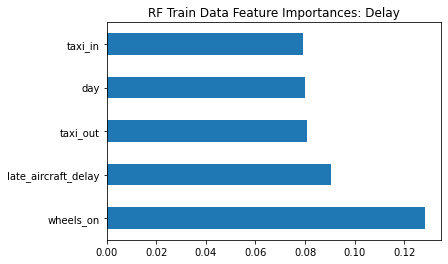

In [96]:
plt.title('RF Train Data Feature Importances: Delay')
(pd.Series(rf_gs.feature_importances_, index=X_delay_test.columns)
   .nlargest(5)
   .plot(kind='barh')) ;

**Task Two: Flight Cancellations:**

_Top 5 Features:_
1) departure_delay
2) is_delay
3) airline_delay
4) late_aircraft_delay
5) wheels_on

**Explination:**
> The two most significant features for predicting flight cancellations are `departure_delay` and `is_delay`. This is expected because the longer a flight is delayed or if a flight is delayed, there is a higher likelihood that it will be cancelled.

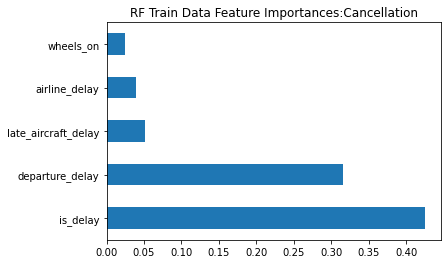

In [97]:
plt.title('RF Train Data Feature Importances:Cancellation')
(pd.Series(rf_cancel.feature_importances_, index=X_cancel_test.columns)
   .nlargest(5)
   .plot(kind='barh')) ;

#### **KNN:**
***
> KNN Algorithm does not provide any prediction for the importance or coefficients of variables. 

***
# Deployment
**How useful is your model for interested parties (i.e., the companies or organizations that might want to use it for prediction)?** <br>
 > Our model would be useful for travelers and airlines. For travellers, having a flight delayed or cancelled can impact their travel plans, especially if there are connecting flights. Being able to identify airlines with higher rates of delays and cancellations can help them make better decisions. As an airline, this could be useful in identifying the major indicators in the different types of delays. For every airline flight cancelled or delayed is money that cannot be recouped and can result in additional paid compensation (lost luggage/ lodging expenses/ food vouchers) while still having to resolve the issue with the customer. <br>
 
 
**How would you measure the model's value if it was used by these parties? How would your deploy your model for interested parties?** <br>
> We would measure the models value as a cost savings to both travelers and airlines. This would be a simple model to deploy and since it uses flight records. Maintaining a database that appends new records could provide timely data for both parties in avoiding travel disruptions and providing flags that may add additional costs to each flight. <br>


**What other data should be collected?**<br>
> Other datapoints that could be useful to add value to the model would be: <br>


| # | Feature Addition | Description | Use Case |
| :--- | :--- | :--- |:--- |
| 1 | Aircraft Model | Plane Models  | This could be used to better understand flight efficiency based on age of and plane sophistication |
| 2 | Maintenance History | Last maintenance check, frequency of tune ups, number of major overhauls | Maintenance history could help determine how fast a plane gets in the air, the speeds it can reach and the turn around from one flight to another |
| 3 | Customer Satisfaction Score | We imagine a survey score on different categories like comfort, entertainment, etc | Customer satisfaction scores could be used to target high priority issues the resolve. An example would be If customers rated the flight with a low timeliness score, turn-around procedures would be identified and reviewed |
| 4 | Pilot Years of Experience | Measured in years or months,  could be categorized by position title  | Our assumption is pilot years of experience may influence how long it takes to get planes off the ground and how they handle weather or flight routes |
| 5 | Flight Costs | Measured in Dollars | This could be a measure for airlines that have little to no delay. Our assumption is punctuality and timeliness could influence consumer trust in an airline, the higher the demand would then in turn result in a higher price. Finding that influences flight costs may be correlated with flight efficiency |
| 6 | Flight Weight | Numeric: in lbs or kg  | Our assumption is a heavier plane takes longer to load and could influence the flight speed which would influence departure and arrival delays  |

<br>**How often would the model need to be updated, etc.?** <br>

> The model would not need major updates unless that is a signiciant change to the industry through regulation or technoloical changes. The model is based on past records that share similar economic and political environments as well as analyzing seasonal travel behavior. If these environments do not change the model should be resilient as time goes on.


***
# Exceptional Work<br>

> For the Exceptional work section, we decided to run a new algorithm that has not been discussed in class. We determined that CatBoost would be a good model to use as it works exceptionally well with categorical data (data set has 21 of 43 features that are categorical) with little to no preprocessing. For this model we redifined features that were previously objects or numerical that were actually categorical. From there we broke the data out into an 80/20 train test split. 

> Once the data was split into a train/test data sets for both Task 1 and Task 2, we ran a CatBoost model that had higher AUC and Accuracy than any previous model we have run. Because models can be overfit, we added a feature `early_stopping_rounds` so that we would not overfit our model. This stopped both models for Task 1 and Task 2 early showing us that if we allowed the model to run through all 1000 iterations, it would be overfit. However, with the `early_stopping_rounds` tuning, we still achieved a high AUC and F1 score. With additinal time, we could look into pruning trees to make sure there was no overfitting.

> Interestingly enough, task 2 catboost model had a perfect AUC curve and was able to accuractly predict a cancellation every time. This fell in line with our previous models from above (LR and RF).


**Model Results:**

Task 1: 

> AUC: 0.9049

Task 2:

> F1: 1.0
***

In [98]:
df_air_catb = df_air.copy()

In [99]:
#convert object fields and category fields 
categories = ['year','month','day','day_of_week','airline_cd','airline_name','flight_number','origin_airport','tail_number',
              'airport_origin','city_origin','state_origin','country_origin','destination_airport','airport_destination',
              'city_destination','state_destination','country_destination','cancellation_reason','is_delay','cancelled']

df_air_catb[categories] = df_air_catb[categories].fillna('Unknown')

In [100]:
df_air_catb[categories] = df_air_catb[categories].astype('category')

In [101]:
df_air_catb.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12514 entries, 321 to 5817010
Data columns (total 38 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   year                   12514 non-null  category
 1   month                  12514 non-null  category
 2   day                    12514 non-null  category
 3   day_of_week            12514 non-null  category
 4   airline_cd             12514 non-null  category
 5   airline_name           12514 non-null  category
 6   flight_number          12514 non-null  category
 7   tail_number            12514 non-null  category
 8   origin_airport         12514 non-null  category
 9   airport_origin         12514 non-null  category
 10  city_origin            12514 non-null  category
 11  state_origin           12514 non-null  category
 12  country_origin         12514 non-null  category
 13  latitude_origin        12514 non-null  float64 
 14  longitude_origin       12514 non-n

In [102]:
#remove target variable and column target was created from training data set
target_cat_delay_cols = ['is_delay','departure_delay']
feature_cat_delay_cols = df_air.loc[:, ~df_air_catb.columns.isin(target_cat_delay_cols)].columns
X_cat_delay = df_air_catb[feature_cat_delay_cols] # Features
y_cat_delay = df_air_catb.is_delay # Target variable

In [103]:
#remove target variable and column target was created from training data set
target_cat_cancel_cols = ['cancelled','cancellation_reason','is_delay']
feature_cat_cancel_cols = df_air.loc[:, ~df_air_catb.columns.isin(target_cat_cancel_cols)].columns
X_cat_cancel = df_air_catb[feature_cat_cancel_cols] # Features
y_cat_cancel = df_air_catb.cancelled # Target variable

In [104]:
#split original dataset into features and target variable
X_cat_delay_train,X_cat_delay_test,y_cat_delay_train,y_cat_delay_test=train_test_split(X_cat_delay,y_cat_delay,test_size=0.20,random_state=0)

In [105]:
#split original dataset into features and target variable
X_cat_cancel_train,X_cat_cancel_test,y_cat_cancel_train,y_cat_cancel_test=train_test_split(X_cat_cancel,y_cat_cancel,test_size=0.20,random_state=0)

In [106]:
#checking shape of data
print('X_cat_delay_train shape: ',X_cat_delay_train.shape,'\n')
print('X_cat_delay_test shape: ',X_cat_delay_test.shape,'\n')
print('y_cat_delay_train shape: ',y_cat_delay_train.shape,'\n')
print('y_cat_delay_test shape: ',y_cat_delay_test.shape)

X_cat_delay_train shape:  (10011, 36) 

X_cat_delay_test shape:  (2503, 36) 

y_cat_delay_train shape:  (10011,) 

y_cat_delay_test shape:  (2503,)


In [107]:
#checking shape of data
print('X_cat_cancel_train shape: ',X_cat_cancel_train.shape,'\n')
print('X_cat_cancel_test shape: ',X_cat_cancel_test.shape,'\n')
print('y_cat_cancel_train shape: ',y_cat_cancel_train.shape,'\n')
print('y_cat_cancel_test shape: ',y_cat_cancel_test.shape)

X_cat_cancel_train shape:  (10011, 35) 

X_cat_cancel_test shape:  (2503, 35) 

y_cat_cancel_train shape:  (10011,) 

y_cat_cancel_test shape:  (2503,)


In [108]:
cat_feat_delay = df_air_catb.select_dtypes(include=['category']).columns.tolist()
cat_feat_cancel = df_air_catb.select_dtypes(include=['category']).columns.tolist()

In [109]:
#remove response variable
cat_feat_delay.remove('is_delay')
cat_feat_cancel.remove('cancelled')
cat_feat_cancel.remove('cancellation_reason')
cat_feat_cancel.remove('is_delay')

In [110]:
%%time
#CatBoost for Is_delay
#https://www.kaggle.com/code/mitribunskiy/tutorial-catboost-overview/notebook

seed = 0
params = {'loss_function':'Logloss', # objective function
          'custom_metric':['AUC','Accuracy','F1'], # metrics
          'verbose': 200, # output to stdout info about training process every 200 iterations
          'random_seed': seed,
          'learning_rate': .25,
          'cat_features':cat_feat_delay,
          'grow_policy': 'Lossguide',
          'thread_count': -1,
          'early_stopping_rounds':200
         }

cbc_delay = CatBoostClassifier(**params)
cbc_delay.fit(X_cat_delay_train, y_cat_delay_train, # data to train on (required parameters, unless we provide X as a pool object, will be shown below)
          eval_set=(X_cat_delay_test, y_cat_delay_test), # data to validate on
          use_best_model=True, # True if we don't want to save trees created after iteration with the best validation score
          plot=True # True for visualization of the training process (it is not shown in a published kernel - try executing this code)
         );

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5501987	test: 0.5539369	best: 0.5539369 (0)	total: 85.4ms	remaining: 1m 25s
200:	learn: 0.1841343	test: 0.3405524	best: 0.3403435 (196)	total: 5.05s	remaining: 20.1s
400:	learn: 0.1149660	test: 0.3396710	best: 0.3312997 (298)	total: 9.48s	remaining: 14.2s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3312997086
bestIteration = 298

Shrink model to first 299 iterations.
CPU times: user 14.1 s, sys: 2.07 s, total: 16.1 s
Wall time: 13.1 s


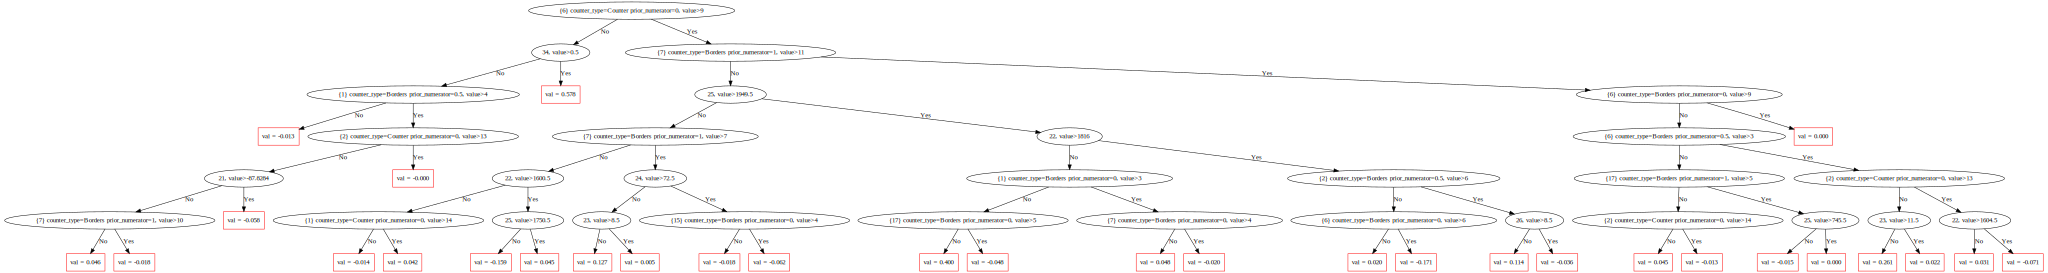

In [111]:
cbc_delay.plot_tree(tree_idx=298)

Text(0.5, 1.0, 'Catboost Feature Importance: Delay')

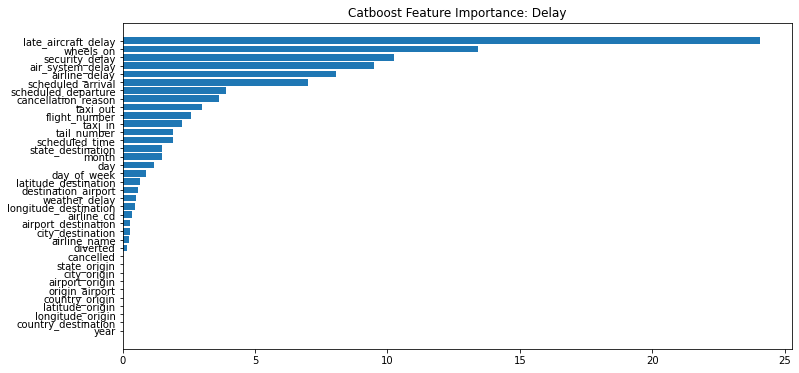

In [112]:

#get feature importance from Catboost model
feature_importance = cbc_delay.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_cat_delay_test.columns)[sorted_idx])
plt.title('Catboost Feature Importance: Delay')

In [113]:
%%time
#CatBoost for Cancellation


#https://www.kaggle.com/code/mitribunskiy/tutorial-catboost-overview/notebook

seed = 0
params = {'loss_function':'Logloss', # objective function
          'custom_metric':['AUC','Accuracy','F1'], # metrics
          'verbose': 200, # output to stdout info about training process every 200 iterations
          'random_seed': seed,
          'learning_rate': .03,
          'cat_features':cat_feat_cancel,
          'thread_count': -1,
          'early_stopping_rounds':200
         }

cbc_cancel = CatBoostClassifier(**params)
cbc_cancel.fit(X_cat_cancel_train, y_cat_cancel_train, # data to train on (required parameters, unless we provide X as a pool object, will be shown below)
          eval_set=(X_cat_cancel_test, y_cat_cancel_test), # data to validate on
          use_best_model=True, # True if we don't want to save trees created after iteration with the best validation score
          plot=True # True for visualization of the training process (it is not shown in a published kernel - try executing this code)
         );

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5770542	test: 0.5773379	best: 0.5773379 (0)	total: 10.5ms	remaining: 10.5s
200:	learn: 0.0000926	test: 0.0000886	best: 0.0000886 (200)	total: 6.41s	remaining: 25.5s
400:	learn: 0.0000418	test: 0.0000420	best: 0.0000420 (400)	total: 11.6s	remaining: 17.4s
600:	learn: 0.0000353	test: 0.0000366	best: 0.0000366 (600)	total: 15.7s	remaining: 10.4s
800:	learn: 0.0000352	test: 0.0000366	best: 0.0000366 (607)	total: 18.9s	remaining: 4.7s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 3.656252238e-05
bestIteration = 607

Shrink model to first 608 iterations.
CPU times: user 27.1 s, sys: 2.03 s, total: 29.1 s
Wall time: 19.4 s


Text(0.5, 1.0, 'Catboost Feature Importance: Cancellations')

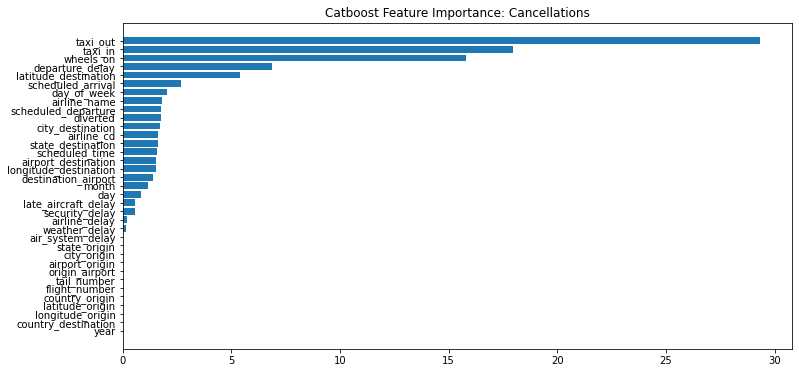

In [114]:
#get feature importance from Catboost model
feature_importance = cbc_cancel.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_cat_cancel_test.columns)[sorted_idx])
plt.title('Catboost Feature Importance: Cancellations')

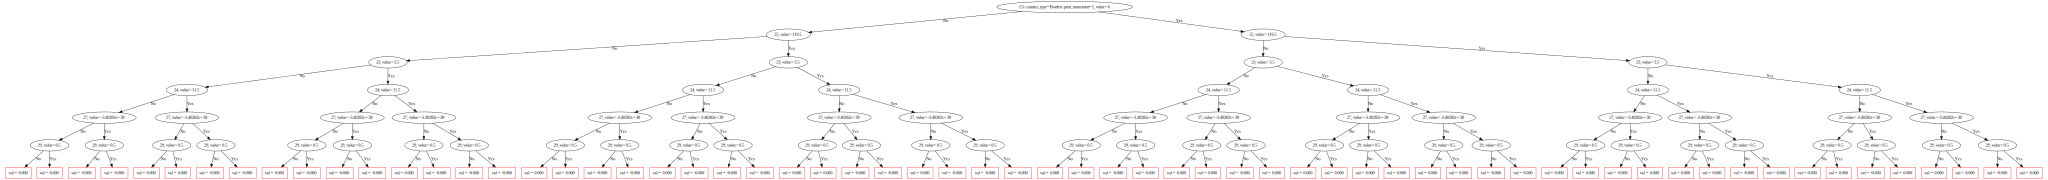

In [115]:
cbc_cancel.plot_tree(tree_idx=607)